In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

2023-05-23 18:41:07.724159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow version: 2.10.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-05-23 18:41:11.750982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-23 18:41:11.928558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-23 18:41:11.930679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Cargo los datos

In [6]:
data = pd.read_csv('ner_datasetreference.csv', encoding='latin1')
data = data.fillna(method='ffill')
data.head(60)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [75]:
data.Tag.value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [76]:
data['Sentence #'].unique()

array(['Sentence: 1', 'Sentence: 2', 'Sentence: 3', ...,
       'Sentence: 47957', 'Sentence: 47958', 'Sentence: 47959'],
      dtype=object)

In [77]:
data.columns

Index(['Sentence #', 'Word', 'POS', 'Tag'], dtype='object')

In [78]:
print("unique words; ",data["Word"].nunique())
print("unique Tag; ",data["Tag"].nunique())

unique words;  35178
unique Tag;  17


In [79]:
#creating dataset for unique words, tags
words = list(set(data["Word"].values))
words.append("ENDPAD")
tags = list(set(data["Tag"].values))

In [80]:
num_words = len(words)
num_tags = len(tags)

In [81]:
class Sentence_getter(object):
    def __init__(self, data):
        self.data = data
        agg_fun = lambda s: [(w, p, t) for w,p,t in zip(s["Word"].values.tolist(),
                                                       s["POS"].values.tolist(),
                                                       s['Tag'].values.tolist())]
        
        self.grouped = self.data.groupby('Sentence #').apply(agg_fun)
        self.sentences = [i for i in self.grouped]

In [82]:
getter = Sentence_getter(data)

In [83]:
sentences = getter.sentences

In [84]:
# Creating vocabulary
word2idx = {w: i+1 for i,w in enumerate(words)}
tag2idx = {t: i for i,t in enumerate(tags)}

In [85]:
tag2idx

{'B-tim': 0,
 'B-art': 1,
 'B-eve': 2,
 'I-geo': 3,
 'B-org': 4,
 'I-art': 5,
 'B-gpe': 6,
 'B-per': 7,
 'B-nat': 8,
 'I-org': 9,
 'B-geo': 10,
 'O': 11,
 'I-per': 12,
 'I-eve': 13,
 'I-nat': 14,
 'I-tim': 15,
 'I-gpe': 16}

[]

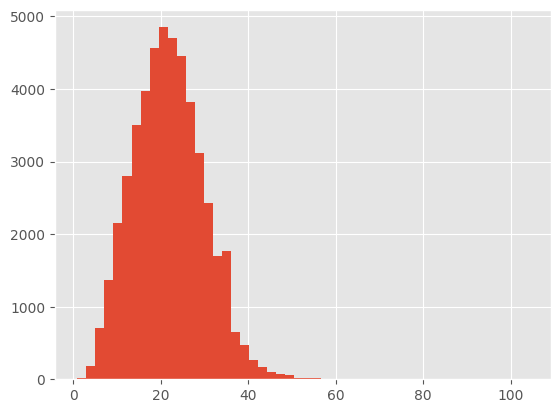

In [86]:
plt.hist([len(s) for s in sentences], bins = 50)
plt.plot()

In [87]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [88]:
max_len = 50


In [89]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences=X, padding='post', value=num_words-1,)

In [91]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences=y, padding='post', value=tag2idx["O"])

In [92]:
y[0]

array([11, 11, 11, 11, 11, 11, 10, 11, 11, 11, 11, 11, 10, 11, 11, 11, 11,
       11,  6, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
      dtype=int32)

In [93]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=1 )

In [94]:
len(x_train)

43163

In [95]:
len(x_test)

4796

In [134]:
x_pos = np.linspace(0,max_len-1).astype(int)

In [154]:
x_pos_train = np.repeat(x_pos.reshape(50,1), len(x_train)).reshape(50, len(x_train)).T
x_pos_test = np.repeat(x_pos.reshape(50,1), len(x_test)).reshape(50, len(x_test)).T

In [155]:
x_pos_train

array([[ 0,  1,  2, ..., 47, 48, 49],
       [ 0,  1,  2, ..., 47, 48, 49],
       [ 0,  1,  2, ..., 47, 48, 49],
       ...,
       [ 0,  1,  2, ..., 47, 48, 49],
       [ 0,  1,  2, ..., 47, 48, 49],
       [ 0,  1,  2, ..., 47, 48, 49]])

# POS con Bidir RNN

In [171]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, Conv1D, Attention, Add, Concatenate
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [110]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=64, input_length=max_len)(input_word)
model = Bidirectional(LSTM(units=100, return_sequences=True))(model)
out = Dense(num_tags, activation='softmax')(model)
model_rnn = Model(input_word, out)
model_rnn.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_13 (Embedding)    (None, 50, 64)            2251456   
                                                                 
 bidirectional_8 (Bidirectio  (None, 50, 200)          132000    
 nal)                                                            
                                                                 
 dense_13 (Dense)            (None, 50, 17)            3417      
                                                                 
Total params: 2,386,873
Trainable params: 2,386,873
Non-trainable params: 0
_________________________________________________________________


In [111]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=64, input_length=max_len)(input_word)
model = Conv1D(20,10,padding="same", activation="relu")(model)
out = Dense(num_tags, activation='softmax')(model)
model_cnn = Model(input_word, out)
model_cnn.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_14 (Embedding)    (None, 50, 64)            2251456   
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 20)            12820     
                                                                 
 dense_14 (Dense)            (None, 50, 17)            357       
                                                                 
Total params: 2,264,633
Trainable params: 2,264,633
Non-trainable params: 0
_________________________________________________________________


In [113]:
model_rnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model_cnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


In [100]:
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras

In [108]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesKeras(), early_stopping]


In [115]:
%%time
history = model_rnn.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size=32,
    epochs=3,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/3
1079/1080 [============================>.] - ETA: 0s - loss: 0.1786 - accuracy: 0.9593


KeyboardInterrupt



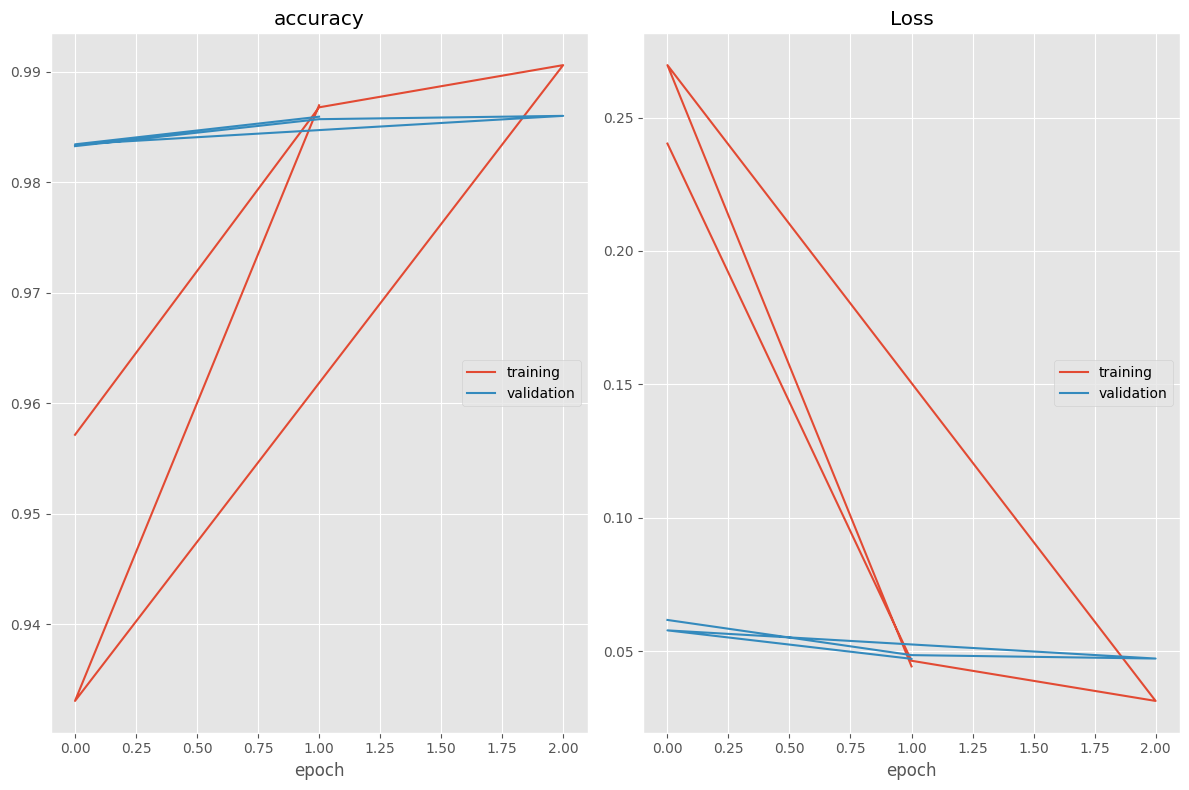

accuracy
	training         	 (min:    0.933, max:    0.991, cur:    0.987)
	validation       	 (min:    0.983, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.031, max:    0.270, cur:    0.044)
	validation       	 (min:    0.047, max:    0.062, cur:    0.047)
1080/1080 [==============================] - 3s 3ms/step - loss: 0.0443 - accuracy: 0.9870 - val_loss: 0.0472 - val_accuracy: 0.9859
Epoch 3/3
   1/1080 [..............................] - ETA: 3s - loss: 0.0320 - accuracy: 0.9894

KeyboardInterrupt: 

In [116]:
%%time
history = model_cnn.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size=32,
    epochs=3,
    verbose=1,
    callbacks=callbacks
)

In [201]:
heads = 4
param = 200
input_word = Input(shape=(max_len,))
input_pos = Input(shape=(max_len,))
suma = Embedding(input_dim=num_words, output_dim=param, input_length=max_len, name="word_embedding")(input_word)
pos = Embedding(input_dim=max_len, output_dim=param, input_length=max_len, name= "pos_embedding")(input_pos)
suma = Add()([suma, pos])

q_1 = [Dense(param, use_bias=False, activation ="linear",name = f'query_1_{i}')(suma) for i in range(heads)]
v_1 = [Dense(param, use_bias=False, activation ="linear",name = f'value_1_{i}')(suma) for i in range(heads)]
k_1 = [Dense(param, use_bias=False, activation ="linear",name = f'key_1_{i}')(suma) for i in range(heads)]

model = [Attention(use_scale=True)([q_1[i],v_1[i],k_1[i]])  for i in range(heads)]
model = Concatenate()(model)
model = Dense(param, activation='relu')(model)
suma = Add()([suma, model])
q_2 = [Dense(param, use_bias=False, activation ="linear",name = f'query_2_{i}')(suma) for i in range(heads)]
v_2 = [Dense(param, use_bias=False, activation ="linear",name = f'value_2_{i}')(suma) for i in range(heads)]
k_2 = [Dense(param, use_bias=False, activation ="linear",name = f'key_2_{i}')(suma) for i in range(heads)]

model = [Attention(use_scale=True)([q_2[i],v_2[i],k_2[i]])  for i in range(heads)]
model = Concatenate()(model)
model = Dense(param, activation='relu')(model)


out = Dense(num_tags, activation='softmax')(model)
model_att = Model([input_word, input_pos], out)
model_att.summary()

Model: "model_44"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_70 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 input_71 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 word_embedding (Embedding)     (None, 50, 200)      7035800     ['input_70[0][0]']               
                                                                                                  
 pos_embedding (Embedding)      (None, 50, 200)      10000       ['input_71[0][0]']               
                                                                                           

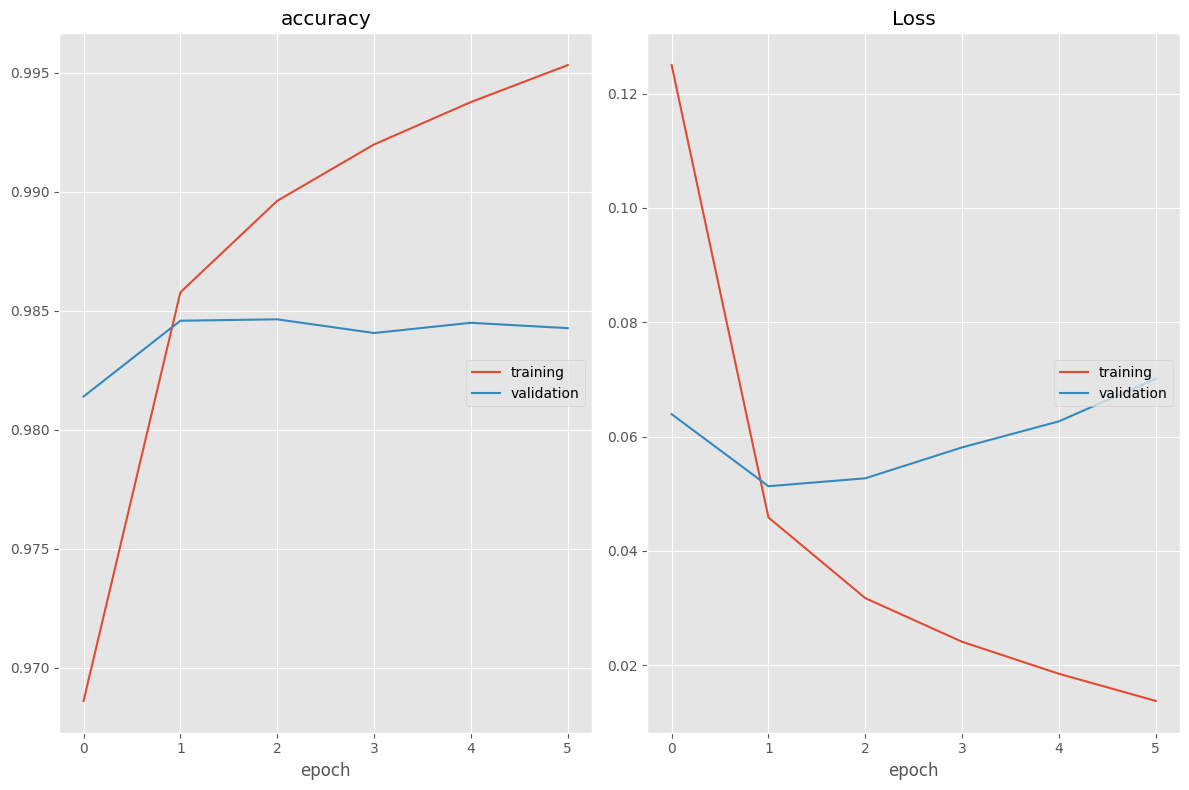

accuracy
	training         	 (min:    0.969, max:    0.995, cur:    0.995)
	validation       	 (min:    0.981, max:    0.985, cur:    0.984)
Loss
	training         	 (min:    0.014, max:    0.125, cur:    0.014)
	validation       	 (min:    0.051, max:    0.070, cur:    0.070)
1349/1349 [==============================] - 15s 11ms/step - loss: 0.0137 - accuracy: 0.9953 - val_loss: 0.0701 - val_accuracy: 0.9843
CPU times: user 2min 16s, sys: 10.7 s, total: 2min 27s
Wall time: 1min 30s


In [202]:
%%time
model_att.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 3, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesKeras(), early_stopping]

history = model_att.fit(
    [x_train, x_pos_train], np.array(y_train),
    validation_data=([x_test,x_pos_test], y_test),
    batch_size=32,
    epochs=10,
    verbose=1,
    callbacks=callbacks
)

In [164]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=64, input_length=max_len)(input_word)
q = Dense(100, use_bias=False, activation ="linear")(model)
v = Dense(100, use_bias=False, activation ="linear")(model)
k = Dense(100, use_bias=False, activation ="linear")(model)
model = Attention()([q,v,k])
out = Dense(num_tags, activation='softmax')(model)
model_att = Model(input_word, out)
model_att.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 embedding_30 (Embedding)       (None, 50, 64)       2251456     ['input_31[0][0]']               
                                                                                                  
 dense_51 (Dense)               (None, 50, 100)      6400        ['embedding_30[0][0]']           
                                                                                                  
 dense_52 (Dense)               (None, 50, 100)      6400        ['embedding_30[0][0]']           
                                                                                           

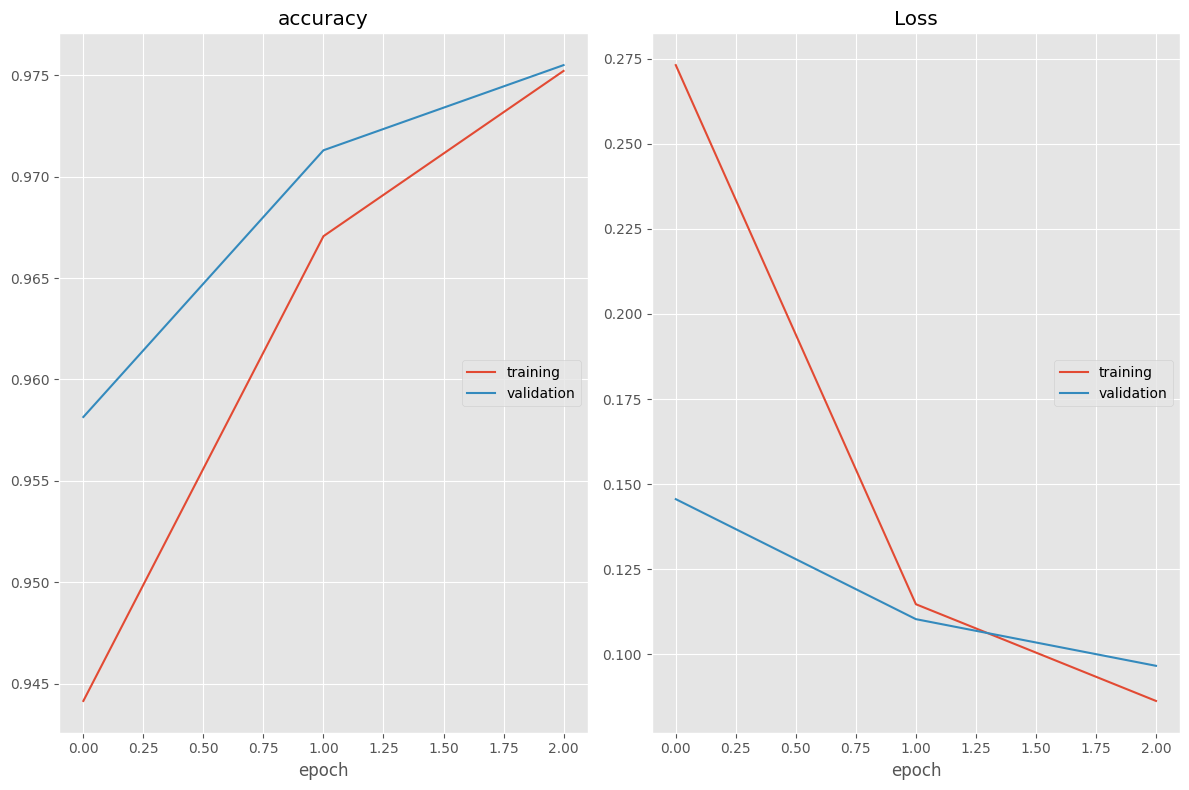

accuracy
	training         	 (min:    0.944, max:    0.975, cur:    0.975)
	validation       	 (min:    0.958, max:    0.976, cur:    0.976)
Loss
	training         	 (min:    0.086, max:    0.273, cur:    0.086)
	validation       	 (min:    0.097, max:    0.146, cur:    0.097)
1080/1080 [==============================] - 3s 3ms/step - loss: 0.0863 - accuracy: 0.9752 - val_loss: 0.0966 - val_accuracy: 0.9755
CPU times: user 18.8 s, sys: 1.63 s, total: 20.5 s
Wall time: 10.5 s


In [165]:
%%time
model_att.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesKeras(), early_stopping]

history = model_att.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size=32,
    epochs=3,
    verbose=1,
    callbacks=callbacks
)